In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import average_precision_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

!pip install gdown
!gdown https://drive.google.com/uc?id=1ZVCQoVuJwLdWSa0ecbECh9CmFNkO0DmE -O model_contrast.pth

Downloading...
From (original): https://drive.google.com/uc?id=1ZVCQoVuJwLdWSa0ecbECh9CmFNkO0DmE
From (redirected): https://drive.google.com/uc?id=1ZVCQoVuJwLdWSa0ecbECh9CmFNkO0DmE&confirm=t&uuid=e7cd4b0b-2fc0-43f7-a841-0b7fd36dc2c5
To: /content/model_contrast.pth
100% 44.8M/44.8M [00:00<00:00, 59.1MB/s]


In [ ]:
# CIFAR-100 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

# 테스트 데이터셋
test_dataset = torchvision.datasets.CIFAR100(root='CIFAR100_Dataset', train=False, download=True, transform=transform)

# 테스트 데이터로더
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print('데이터셋 및 데이터 로더의 준비가 완료되었습니다!')

100%|██████████| 169M/169M [00:01<00:00, 104MB/s]


데이터셋 및 데이터 로더의 준비가 완료되었습니다!


In [ ]:
# 특징 추출을 위한 ResNet18 딥러닝 네트워크
class ResNet18FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet18FeatureExtractor, self).__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Fully Connected Layer 제거

    def forward(self, x):
        x = self.feature_extractor(x)
        return x.view(x.size(0), -1)  # Flatten to [batch_size, feature_dim]

# 연산 장치 설정 (GPU가 사용가능 하면 GPU사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 이미지 특징 추출을 위한 ResNet18 딥러닝 네트워크 선언
model_original = ResNet18FeatureExtractor() # 대조 학습을 적용하지 않은 원래 네트워크
model_contrast = ResNet18FeatureExtractor() # 대조 학습을 적용한 새로운 네트워크

# 대조 학습된 모델 불러오기
model_contrast.load_state_dict(torch.load('/content/model_contrast.pth'))

# 두 딥러닝 네트워크를 연산장치로 보냄
model_original = model_original.to(device)
model_contrast = model_contrast.to(device)

# 모델 평가모드
model_original.eval()
model_contrast.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]


ResNet18FeatureExtractor(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [ ]:
# 데이터 로더로 부터 나온 이미지 특징 추출하는 함수
def extract_features(model, dataloader):  # model: 딥러닝 네트워크, dataloader: 데이터로더
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Extracting Features"):
            inputs = inputs.to(device)
            outputs = model(inputs)  # Feature extraction
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

features_original, labels_original = extract_features(model_original, test_dataloader)
features_contrast, labels_contrast = extract_features(model_contrast, test_dataloader)

print('\n\n 각 딥러닝 네트워크들을 사용해 특징 추출이 완료됐습니다!')

Extracting Features: 100%|██████████| 79/79 [01:52<00:00,  1.43s/it]




 각 딥러닝 네트워크들을 사용해 특징 추출이 완료됐습니다!


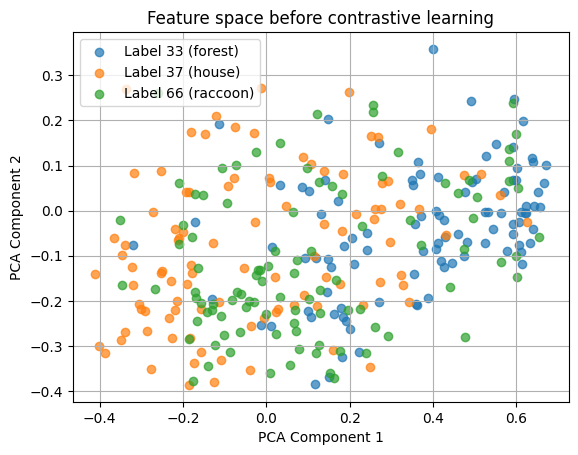

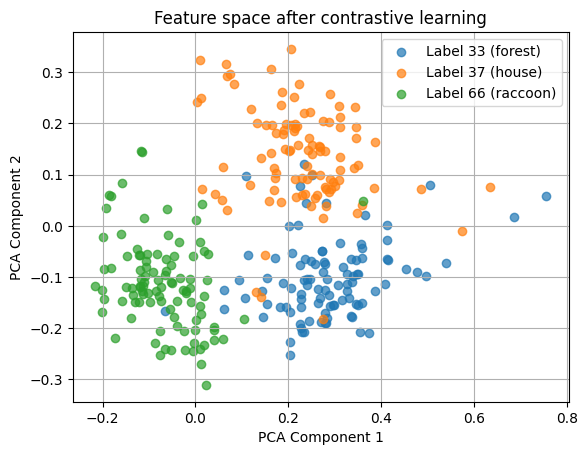

In [ ]:

def show_feature(features, labels, title):
    # 특징 정규화
    features = features / np.linalg.norm(features, axis = 1)[:, None]

    # PCA 적용하여 2차원으로 축소
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)

    # 라벨별로 시각화
    label_range = np.array([33, 37, 66])  # 사용할 라벨 지정

    for label in label_range:
        idxs = labels == label
        plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=f'Label {label} ({test_dataset.classes[label]})', alpha=0.7)

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# 시각화 실행
show_feature(features_original, labels_original, 'Feature space before contrastive learning')
show_feature(features_contrast, labels_contrast, 'Feature space after contrastive learning')

## **두 딥러닝 네트워크의 특징 공간이 어떤가요? 우리가 원하는대로 대조 학습의 결과가 나왔나요?**

대조 학습을 적용한 후에는 같은 종류의 이미지들이 더 가깝게 모였고, 다른 종류의 이미지들은 더 멀리 떨어져서 특징공간이 더 잘 구분되었습니다. 따라서 의도한 대로 대조학습이 잘 이루어 졌다고 볼 수 있습니다.

## **느낀점**

이번 5차시 실습을 통해 인공지능이 이미지를 단순히 보는 것이 아니라, 숫자로 바꾸고, 특징을 추출하고, 서로 비교하면서 학습한다는 과정을 직접 확인할 수 있었습니다.. 특히 대조 학습을 적용했을 때 이미지들이 더 잘 구분되는 것이 눈에 보여서 인공지능 학습 방법의 중요성을 느끼게 되었습니다. 이번 실습을 통해 인공지능이 생각보다 훨씬 똑똑하게 학습한다는 것도 알게 되었고, 나도 앞으로 인공지능을 더 잘 공부해 보고 싶다는 생각이 들었습니다.